In [ ]:
! pip uninstall torch torchvision -y
! pip install torch==1.4.0 torchvision==0.5.0

Uninstalling torch-1.4.0:
  Successfully uninstalled torch-1.4.0
Uninstalling torchvision-0.5.0:
  Successfully uninstalled torchvision-0.5.0
  Using cached https://files.pythonhosted.org/packages/24/19/4804aea17cd136f1705a5e98a00618cb8f6ccc375ad8bfa437408e09d058/torch-1.4.0-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/7e/90/6141bf41f5655c78e24f40f710fdd4f8a8aff6c8b7c6f0328240f649bdbe/torchvision-0.5.0-cp36-cp36m-manylinux1_x86_64.whl


In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import torch
import torchvision
import matplotlib
import pickle
import numpy
import platform

print('python version:      {}'.format(platform.python_version()))
print('torch version:       {}'.format(torch.__version__))
print('torchvision version: {}'.format(torchvision.__version__))
print('numpy version:       {}'.format(numpy.__version__))
print('matplotlib version:  {}'.format(matplotlib.__version__))
print('pickle version:      {}'.format(pickle.format_version))

import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
import numpy as np

use_cuda = torch.cuda.is_available()
print('CUDA available:      {}'.format(use_cuda))
print('cuDNN enabled:       {}'.format(torch.backends.cudnn.enabled))
print('num gpus:            {}'.format(torch.cuda.device_count()))
print('gpu:                 {}'.format(torch.cuda.get_device_name(0)))

python version:      3.6.9
torch version:       1.4.0
torchvision version: 0.5.0
numpy version:       1.18.5
matplotlib version:  3.2.2
pickle version:      4.0
CUDA available:      True
cuDNN enabled:       True
num gpus:            1
gpu:                 Tesla K80


Set CUDNN to deterministic for reproducibility reasons:

In [ ]:
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Mount GDrive:

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
base_url = '/content/gdrive/My Drive/neuralnet-patchinit/'

# Data

## Specify Dataset

Define data transform functions:

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

Define training and test set:

In [ ]:
# training set
trainset = torchvision.datasets.MNIST(
    root='./data', train=True, download=True, transform=transform
)

# test set
testset = torchvision.datasets.MNIST(
    root='./data', train=False, download=True, transform=transform
)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


## Load Data

In [ ]:
batch_size_train = 64  # https://github.com/BVLC/caffe/blob/master/examples/mnist/lenet_train_test.prototxt
batch_size_test = 1000

Create train and test data loader:

In [ ]:
# create training data loader
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size_train, shuffle=True, num_workers=2
)

# create test data loader
testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size_test, shuffle=False, num_workers=2
)

## Display Samples

In [ ]:
def show_samples(data, targets):
    data = data.numpy()
    print("tensor shape: " + str(data.shape))
    
    fig = plt.figure()
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.tight_layout()
        
        img = data * 0.3081 + 0.1307  # unnormalize
        plt.imshow(img[i][0], cmap='gray', interpolation='none')
        plt.title("Ground Truth: {}".format(targets[i]))
        
        plt.xticks([])
        plt.yticks([])

Load a few test images and display them:

tensor shape: (1000, 1, 28, 28)


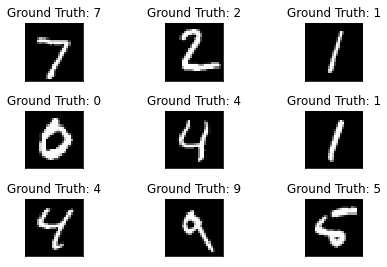

In [ ]:
dataiter = enumerate(testloader)
_, (sample_data, sample_targets) = next(dataiter)

show_samples(sample_data, sample_targets)

# Define Training and Test Methods

In [ ]:
def train(num_epochs, model, optim, crit, train_loader, test_loader):
    train_losses = []
    test_losses = []
    test_accs = []
    
    for epoch in range(1, num_epochs + 1):
        model, train_losses = train_one_epoch(epoch, model, optim, crit, train_loader, train_losses)
        test_losses, test_accs = test(model, crit, test_loader, test_losses, test_accs)
        
    print('Finished Training')
    return train_losses, test_losses, test_accs
    

def train_one_epoch(epoch_num, model, optim, crit, data_loader, losses):
    model.train()
    running_loss = 0.0
    
    for batch_idx, data in enumerate(data_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, targets = data

        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        
        # zero the parameter gradients
        optim.zero_grad()
        
        # forward + backward + optimize
        outputs = model(inputs)
        loss = crit(outputs, targets)
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        
        if batch_idx % log_interval == 0:
            dataset_size = len(data_loader.dataset)
            used_samples = batch_idx * len(inputs)
            train_progress = 100. * batch_idx / len(data_loader)
            avg_batch_loss = running_loss / log_interval
            
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch_num, used_samples, dataset_size, train_progress, avg_batch_loss
            ))
            
            losses.append(avg_batch_loss)
            running_loss = 0.0
            
    return model, losses
     
    
def test(model, crit, data_loader, test_losses, test_accs):
    model.eval()
    correct = 0
    test_loss = 0
    
    with torch.no_grad():
        for data in data_loader:
            # get the inputs; data is a list of [inputs, labels]
            inputs, targets = data

            if use_cuda:
              inputs, targets = inputs.cuda(), targets.cuda()
            
            # forward + loss + correct
            outputs = model(inputs)
            test_loss += crit(outputs, targets).item()
            
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == targets).sum().item()
          
    dataset_size = len(data_loader.dataset)
    test_loss /= dataset_size
    acc = 100. * correct / dataset_size
    
    test_losses.append(test_loss)
    test_accs.append(acc)
    
    print('\nTest set: Avg. loss: {:.6f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, dataset_size, acc
    ))
    
    return test_losses, test_accs

# LeNet Architecture

LeNet (https://github.com/BVLC/caffe/blob/master/examples/mnist/lenet.prototxt):

In [ ]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, kernel_size=5)
        self.conv2 = nn.Conv2d(20, 50, kernel_size=5)
        self.fc1 = nn.Linear(800, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, 800)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Create Random Seed Values

Create 5 random numbers (between 0 and 99) for seed values:

In [ ]:
#random_seed_list = np.random.choice(np.arange(100), 5)
#random_seed_list

In [ ]:
#with open(base_url + "random-seeds.txt", "wb") as fp:
#  pickle.dump(random_seed_list, fp)

In [ ]:
with open(base_url + "random-seeds.txt", "rb") as fp:
  random_seed_list = pickle.load(fp)

random_seed_list

array([76, 90, 32, 23, 12])

# Patch Init

## Create Patch based Weight Init

In [ ]:
random_seed = 1
torch.manual_seed(random_seed)
np.random.seed(random_seed)

### Load Patches

In [ ]:
def show_patches(patches):
    print("tensor shape: " + str(patches.shape))
    
    fig = plt.figure(figsize=(8,8))
    for i in range(patches.shape[0]):
        plt.subplot(5,4,i+1)
        plt.tight_layout()
        plt.imshow(patches[i], cmap='gray', interpolation='none')
        plt.xticks([])
        plt.yticks([])

Load data to get the patches:

In [ ]:
patch_path = '/content/gdrive/My Drive/neuralnet-patchinit/mnist_kmeans/mnist_patches_avg_more_umap_kmeans2.txt'

with open(patch_path, "rb") as fp:
    patches = pickle.load(fp)

patches = patches.astype(np.float32)
patches.shape, patches.dtype

((20, 14, 14), dtype('float32'))

tensor shape: (20, 14, 14)


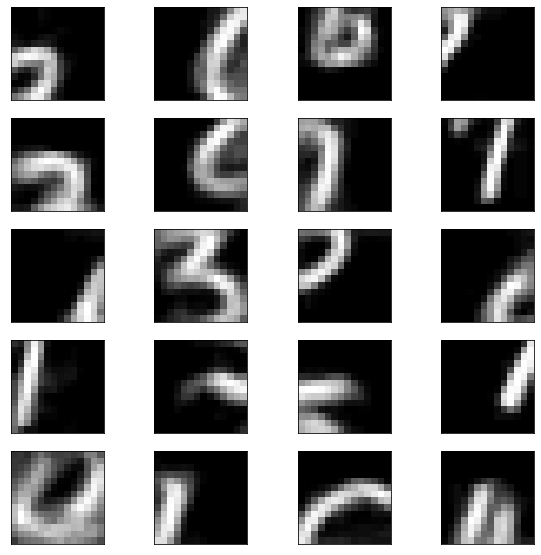

In [ ]:
show_patches(patches)

### Remove Zeros

In [ ]:
def remove_zeros(patches):
    mask = patches == 0.0
    n_null = np.sum(mask, axis=(1,2))
    a = np.sum(patches, axis=(1,2)) 
    
    for i in range(patches.shape[0]):
        p = patches[i]
        p[p == 0] = -1.0 * a[i] / n_null[i]
        patches[i] = p
        
    return patches

In [ ]:
patches = remove_zeros(patches)

### Downsample Patches

In [ ]:
patches = np.expand_dims(patches,1)
patches = torch.from_numpy(patches)
patches = F.interpolate(patches, size=5, mode='bilinear')

print("tensor shape: " + str(patches.shape))

tensor shape: torch.Size([20, 1, 5, 5])


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


min value: -6.046029090881348
max value: 0.9700883030891418
tensor shape: torch.Size([20, 5, 5])


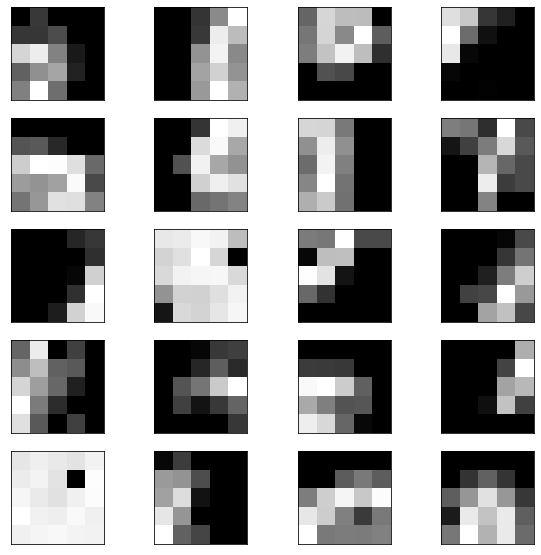

In [ ]:
print("min value: " + str(torch.min(patches).item()))
print("max value: " + str(torch.max(patches).item()))
show_patches(patches.squeeze(1))

## Training

### WD = 0.0005

In [ ]:
num_epochs = 20

learning_rate = 0.01
momentum = 0.9
weight_decay = 0.0005

log_interval = 10

Create model and start training for each of the 5 seeds:

In [ ]:
accs_patchinit_wd00005_paths = []

for s in random_seed_list:
    print('Seed = {} =============================================='.format(s))
    
    # Set Seed Value
    torch.manual_seed(s)
    np.random.seed(s)
    
    # Create Model
    network = LeNet()

    if use_cuda:
      network.cuda()
      #network = torch.nn.DataParallel(network)
      print('Using ', torch.cuda.device_count(), ' GPU(s)')

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)

    # Set Patches as Weight Tensor
    patches.requires_grad = True

    with torch.no_grad():
      network.conv1.weight =  nn.Parameter(patches.clone().cuda())

    print()
    print("conv1 weights shape: " + str(network.conv1.weight.shape))
    print("min value:           " + str(torch.min(network.conv1.weight).item()))
    print("max value:           " + str(torch.max(network.conv1.weight).item()))
    print()
    
    # Start Training
    _, _, patchinit_test_accs_tmp = train(num_epochs, network, optimizer, criterion, trainloader, testloader)
    
    # Save Result
    result_path = base_url + "results/accs-mnist-patchinit-kmeans-avg-wd00005-seed{}.txt".format(s)
    accs_patchinit_wd00005_paths.append(result_path)
    with open(result_path, "wb") as fp:
        pickle.dump(patchinit_test_accs_tmp, fp)

    print()

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
Train Epoch: 9 [41600/60000 (69%)]	Loss: 0.006713
Train Epoch: 9 [42240/60000 (70%)]	Loss: 0.022292
Train Epoch: 9 [42880/60000 (71%)]	Loss: 0.009412
Train Epoch: 9 [43520/60000 (72%)]	Loss: 0.015639
Train Epoch: 9 [44160/60000 (74%)]	Loss: 0.014478
Train Epoch: 9 [44800/60000 (75%)]	Loss: 0.007924
Train Epoch: 9 [45440/60000 (76%)]	Loss: 0.012054
Train Epoch: 9 [46080/60000 (77%)]	Loss: 0.007229
Train Epoch: 9 [46720/60000 (78%)]	Loss: 0.004617
Train Epoch: 9 [47360/60000 (79%)]	Loss: 0.010959
Train Epoch: 9 [48000/60000 (80%)]	Loss: 0.005958
Train Epoch: 9 [48640/60000 (81%)]	Loss: 0.004851
Train Epoch: 9 [49280/60000 (82%)]	Loss: 0.006107
Train Epoch: 9 [49920/60000 (83%)]	Loss: 0.004743
Train Epoch: 9 [50560/60000 (84%)]	Loss: 0.003511
Train Epoch: 9 [51200/60000 (85%)]	Loss: 0.004026
Train Epoch: 9 [51840/60000 (86%)]	Loss: 0.003714
Train Epoch: 9 [52480/60000 (87%)]	Loss: 0.004558
Train Epoch: 9 [53120/60000 (88%)

### WD = 0.05

In [ ]:
num_epochs = 20

learning_rate = 0.01
momentum = 0.9
weight_decay = 0.05

log_interval = 10

Create model and start training for each of the 5 seeds:

In [ ]:
accs_patchinit_wd005_paths = []

for s in random_seed_list:
    print('Seed = {} =============================================='.format(s))
    
    # Set Seed Value
    torch.manual_seed(s)
    np.random.seed(s)
    
    # Create Model
    network = LeNet()

    if use_cuda:
      network.cuda()
      #network = torch.nn.DataParallel(network)
      print('Using ', torch.cuda.device_count(), ' GPU(s)')

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)

    # Set Patches as Weight Tensor
    patches.requires_grad = True

    with torch.no_grad():
      network.conv1.weight =  nn.Parameter(patches.clone().cuda())

    print()
    print("conv1 weights shape: " + str(network.conv1.weight.shape))
    print("min value:           " + str(torch.min(network.conv1.weight).item()))
    print("max value:           " + str(torch.max(network.conv1.weight).item()))
    print()
    
    # Start Training
    _, _, patchinit_test_accs_tmp = train(num_epochs, network, optimizer, criterion, trainloader, testloader)
    
    # Save Result
    result_path = base_url + "results/accs-mnist-patchinit-kmeans-avg-wd005-seed{}.txt".format(s)
    accs_patchinit_wd005_paths.append(result_path)
    with open(result_path, "wb") as fp:
        pickle.dump(patchinit_test_accs_tmp, fp)

    print()

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
Train Epoch: 9 [41600/60000 (69%)]	Loss: 0.140344
Train Epoch: 9 [42240/60000 (70%)]	Loss: 0.126840
Train Epoch: 9 [42880/60000 (71%)]	Loss: 0.098905
Train Epoch: 9 [43520/60000 (72%)]	Loss: 0.121119
Train Epoch: 9 [44160/60000 (74%)]	Loss: 0.125508
Train Epoch: 9 [44800/60000 (75%)]	Loss: 0.087833
Train Epoch: 9 [45440/60000 (76%)]	Loss: 0.117115
Train Epoch: 9 [46080/60000 (77%)]	Loss: 0.113885
Train Epoch: 9 [46720/60000 (78%)]	Loss: 0.109564
Train Epoch: 9 [47360/60000 (79%)]	Loss: 0.118860
Train Epoch: 9 [48000/60000 (80%)]	Loss: 0.112198
Train Epoch: 9 [48640/60000 (81%)]	Loss: 0.144447
Train Epoch: 9 [49280/60000 (82%)]	Loss: 0.119854
Train Epoch: 9 [49920/60000 (83%)]	Loss: 0.098126
Train Epoch: 9 [50560/60000 (84%)]	Loss: 0.103101
Train Epoch: 9 [51200/60000 (85%)]	Loss: 0.097184
Train Epoch: 9 [51840/60000 (86%)]	Loss: 0.142785
Train Epoch: 9 [52480/60000 (87%)]	Loss: 0.170396
Train Epoch: 9 [53120/60000 (88%)

### WD = 0.005

In [ ]:
num_epochs = 20

learning_rate = 0.01
momentum = 0.9
weight_decay = 0.005

log_interval = 10

Create model and start training for each of the 5 seeds:

In [ ]:
accs_patchinit_wd0005_paths = []

for s in random_seed_list:
    print('Seed = {} =============================================='.format(s))
    
    # Set Seed Value
    torch.manual_seed(s)
    np.random.seed(s)
    
    # Create Model
    network = LeNet()

    if use_cuda:
      network.cuda()
      #network = torch.nn.DataParallel(network)
      print('Using ', torch.cuda.device_count(), ' GPU(s)')

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)

    # Set Patches as Weight Tensor
    patches.requires_grad = True

    with torch.no_grad():
      network.conv1.weight =  nn.Parameter(patches.clone().cuda())

    print()
    print("conv1 weights shape: " + str(network.conv1.weight.shape))
    print("min value:           " + str(torch.min(network.conv1.weight).item()))
    print("max value:           " + str(torch.max(network.conv1.weight).item()))
    print()
    
    # Start Training
    _, _, patchinit_test_accs_tmp = train(num_epochs, network, optimizer, criterion, trainloader, testloader)
    
    # Save Result
    result_path = base_url + "results/accs-mnist-patchinit-kmeans-avg-wd0005-seed{}.txt".format(s)
    accs_patchinit_wd0005_paths.append(result_path)
    with open(result_path, "wb") as fp:
        pickle.dump(patchinit_test_accs_tmp, fp)

    print()

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
Train Epoch: 9 [41600/60000 (69%)]	Loss: 0.037052
Train Epoch: 9 [42240/60000 (70%)]	Loss: 0.047695
Train Epoch: 9 [42880/60000 (71%)]	Loss: 0.037644
Train Epoch: 9 [43520/60000 (72%)]	Loss: 0.028614
Train Epoch: 9 [44160/60000 (74%)]	Loss: 0.044958
Train Epoch: 9 [44800/60000 (75%)]	Loss: 0.017727
Train Epoch: 9 [45440/60000 (76%)]	Loss: 0.029709
Train Epoch: 9 [46080/60000 (77%)]	Loss: 0.032685
Train Epoch: 9 [46720/60000 (78%)]	Loss: 0.033409
Train Epoch: 9 [47360/60000 (79%)]	Loss: 0.042397
Train Epoch: 9 [48000/60000 (80%)]	Loss: 0.031141
Train Epoch: 9 [48640/60000 (81%)]	Loss: 0.026960
Train Epoch: 9 [49280/60000 (82%)]	Loss: 0.054638
Train Epoch: 9 [49920/60000 (83%)]	Loss: 0.051124
Train Epoch: 9 [50560/60000 (84%)]	Loss: 0.030320
Train Epoch: 9 [51200/60000 (85%)]	Loss: 0.035649
Train Epoch: 9 [51840/60000 (86%)]	Loss: 0.046978
Train Epoch: 9 [52480/60000 (87%)]	Loss: 0.049185
Train Epoch: 9 [53120/60000 (88%)

### WD = 0.00005

In [ ]:
num_epochs = 20

learning_rate = 0.01
momentum = 0.9
weight_decay = 0.00005

log_interval = 10

Create model and start training for each of the 5 seeds:

In [ ]:
accs_patchinit_wd000005_paths = []

for s in random_seed_list:
    print('Seed = {} =============================================='.format(s))
    
    # Set Seed Value
    torch.manual_seed(s)
    np.random.seed(s)
    
    # Create Model
    network = LeNet()

    if use_cuda:
      network.cuda()
      #network = torch.nn.DataParallel(network)
      print('Using ', torch.cuda.device_count(), ' GPU(s)')

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)

    # Set Patches as Weight Tensor
    patches.requires_grad = True

    with torch.no_grad():
      network.conv1.weight =  nn.Parameter(patches.clone().cuda())

    print()
    print("conv1 weights shape: " + str(network.conv1.weight.shape))
    print("min value:           " + str(torch.min(network.conv1.weight).item()))
    print("max value:           " + str(torch.max(network.conv1.weight).item()))
    print()
    
    # Start Training
    _, _, patchinit_test_accs_tmp = train(num_epochs, network, optimizer, criterion, trainloader, testloader)
    
    # Save Result
    result_path = base_url + "results/accs-mnist-patchinit-kmeans-avg-wd000005-seed{}.txt".format(s)
    accs_patchinit_wd000005_paths.append(result_path)
    with open(result_path, "wb") as fp:
        pickle.dump(patchinit_test_accs_tmp, fp)

    print()

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
Train Epoch: 9 [41600/60000 (69%)]	Loss: 0.001676
Train Epoch: 9 [42240/60000 (70%)]	Loss: 0.005394
Train Epoch: 9 [42880/60000 (71%)]	Loss: 0.002358
Train Epoch: 9 [43520/60000 (72%)]	Loss: 0.002569
Train Epoch: 9 [44160/60000 (74%)]	Loss: 0.003815
Train Epoch: 9 [44800/60000 (75%)]	Loss: 0.003015
Train Epoch: 9 [45440/60000 (76%)]	Loss: 0.005302
Train Epoch: 9 [46080/60000 (77%)]	Loss: 0.001588
Train Epoch: 9 [46720/60000 (78%)]	Loss: 0.003436
Train Epoch: 9 [47360/60000 (79%)]	Loss: 0.001797
Train Epoch: 9 [48000/60000 (80%)]	Loss: 0.002685
Train Epoch: 9 [48640/60000 (81%)]	Loss: 0.001422
Train Epoch: 9 [49280/60000 (82%)]	Loss: 0.006743
Train Epoch: 9 [49920/60000 (83%)]	Loss: 0.002263
Train Epoch: 9 [50560/60000 (84%)]	Loss: 0.012478
Train Epoch: 9 [51200/60000 (85%)]	Loss: 0.002897
Train Epoch: 9 [51840/60000 (86%)]	Loss: 0.013046
Train Epoch: 9 [52480/60000 (87%)]	Loss: 0.008679
Train Epoch: 9 [53120/60000 (88%)

### WD = 0.000005

In [ ]:
num_epochs = 20

learning_rate = 0.01
momentum = 0.9
weight_decay = 0.000005

log_interval = 10

Create model and start training for each of the 5 seeds:

In [ ]:
accs_patchinit_wd0000005_paths = []

for s in random_seed_list:
    print('Seed = {} =============================================='.format(s))
    
    # Set Seed Value
    torch.manual_seed(s)
    np.random.seed(s)
    
    # Create Model
    network = LeNet()

    if use_cuda:
      network.cuda()
      #network = torch.nn.DataParallel(network)
      print('Using ', torch.cuda.device_count(), ' GPU(s)')

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)

    # Set Patches as Weight Tensor
    patches.requires_grad = True

    with torch.no_grad():
      network.conv1.weight =  nn.Parameter(patches.clone().cuda())

    print()
    print("conv1 weights shape: " + str(network.conv1.weight.shape))
    print("min value:           " + str(torch.min(network.conv1.weight).item()))
    print("max value:           " + str(torch.max(network.conv1.weight).item()))
    print()
    
    # Start Training
    _, _, patchinit_test_accs_tmp = train(num_epochs, network, optimizer, criterion, trainloader, testloader)
    
    # Save Result
    result_path = base_url + "results/accs-mnist-patchinit-kmeans-avg-wd0000005-seed{}.txt".format(s)
    accs_patchinit_wd0000005_paths.append(result_path)
    with open(result_path, "wb") as fp:
        pickle.dump(patchinit_test_accs_tmp, fp)

    print()

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
Train Epoch: 9 [41600/60000 (69%)]	Loss: 0.001201
Train Epoch: 9 [42240/60000 (70%)]	Loss: 0.007634
Train Epoch: 9 [42880/60000 (71%)]	Loss: 0.005279
Train Epoch: 9 [43520/60000 (72%)]	Loss: 0.002451
Train Epoch: 9 [44160/60000 (74%)]	Loss: 0.004968
Train Epoch: 9 [44800/60000 (75%)]	Loss: 0.001590
Train Epoch: 9 [45440/60000 (76%)]	Loss: 0.003755
Train Epoch: 9 [46080/60000 (77%)]	Loss: 0.002030
Train Epoch: 9 [46720/60000 (78%)]	Loss: 0.000655
Train Epoch: 9 [47360/60000 (79%)]	Loss: 0.000862
Train Epoch: 9 [48000/60000 (80%)]	Loss: 0.003793
Train Epoch: 9 [48640/60000 (81%)]	Loss: 0.006727
Train Epoch: 9 [49280/60000 (82%)]	Loss: 0.005121
Train Epoch: 9 [49920/60000 (83%)]	Loss: 0.001249
Train Epoch: 9 [50560/60000 (84%)]	Loss: 0.004019
Train Epoch: 9 [51200/60000 (85%)]	Loss: 0.004194
Train Epoch: 9 [51840/60000 (86%)]	Loss: 0.005710
Train Epoch: 9 [52480/60000 (87%)]	Loss: 0.002788
Train Epoch: 9 [53120/60000 (88%)

# Results

In [ ]:
def plot_results(results, names, stds, ymin):
    for i in range(len(results)):
        x = np.arange(len(results[i]))
        plt.errorbar(x, results[i], yerr=stds[i])
    
    plt.legend(names)
    plt.ylim(ymin, 100)
    plt.show()

Get results from kaiming uniform and patch init with wd = 0.0005:

In [ ]:
accs_sota_ukaim_wd00005_paths = [
  base_url + 'results/accs-mnist-sota-ukaim-wd00005-seed76.txt',
  base_url + 'results/accs-mnist-sota-ukaim-wd00005-seed90.txt',
  base_url + 'results/accs-mnist-sota-ukaim-wd00005-seed32.txt',
  base_url + 'results/accs-mnist-sota-ukaim-wd00005-seed23.txt',
  base_url + 'results/accs-mnist-sota-ukaim-wd00005-seed12.txt',
]
accs_sota_ukaim_wd00005_results = []

for p in accs_sota_ukaim_wd00005_paths:
    # Load Results
    with open(p, "rb") as fp:
        test_accs_tmp = pickle.load(fp)
        
    accs_sota_ukaim_wd00005_results.append(test_accs_tmp)

accs_sota_ukaim_wd00005_results = np.array(accs_sota_ukaim_wd00005_results)
avg_accs_sota_ukaim_wd00005_results = np.mean(accs_sota_ukaim_wd00005_results, axis=0)
std_accs_sota_ukaim_wd00005_results = np.std(accs_sota_ukaim_wd00005_results, axis=0)

In [ ]:
accs_patchinit_wd00005_paths = [
  base_url + 'results/accs-mnist-patchinit-kmeans-avg-wd00005-seed76.txt',
  base_url + 'results/accs-mnist-patchinit-kmeans-avg-wd00005-seed90.txt',
  base_url + 'results/accs-mnist-patchinit-kmeans-avg-wd00005-seed32.txt',
  base_url + 'results/accs-mnist-patchinit-kmeans-avg-wd00005-seed23.txt',
  base_url + 'results/accs-mnist-patchinit-kmeans-avg-wd00005-seed12.txt',
]
accs_patchinit_wd00005_results = []

for p in accs_patchinit_wd00005_paths:
    # Load Results
    with open(p, "rb") as fp:
        test_accs_tmp = pickle.load(fp)
        
    accs_patchinit_wd00005_results.append(test_accs_tmp)

accs_patchinit_wd00005_results = np.array(accs_patchinit_wd00005_results)
avg_accs_patchinit_wd00005_results = np.mean(accs_patchinit_wd00005_results, axis=0)
std_accs_patchinit_wd00005_results = np.std(accs_patchinit_wd00005_results, axis=0)

Get results from kaiming uniform and patch init with wd = 0.005:

In [ ]:
accs_sota_ukaim_wd0005_paths = [
  base_url + 'results/accs-mnist-sota-ukaim-wd0005-seed76.txt',
  base_url + 'results/accs-mnist-sota-ukaim-wd0005-seed90.txt',
  base_url + 'results/accs-mnist-sota-ukaim-wd0005-seed32.txt',
  base_url + 'results/accs-mnist-sota-ukaim-wd0005-seed23.txt',
  base_url + 'results/accs-mnist-sota-ukaim-wd0005-seed12.txt',
]
accs_sota_ukaim_wd0005_results = []

for p in accs_sota_ukaim_wd0005_paths:
    # Load Results
    with open(p, "rb") as fp:
        test_accs_tmp = pickle.load(fp)
        
    accs_sota_ukaim_wd0005_results.append(test_accs_tmp)

accs_sota_ukaim_wd0005_results = np.array(accs_sota_ukaim_wd0005_results)
avg_accs_sota_ukaim_wd0005_results = np.mean(accs_sota_ukaim_wd0005_results, axis=0)
std_accs_sota_ukaim_wd0005_results = np.std(accs_sota_ukaim_wd0005_results, axis=0)

In [ ]:
accs_patchinit_wd0005_paths = [
  base_url + 'results/accs-mnist-patchinit-kmeans-avg-wd0005-seed76.txt',
  base_url + 'results/accs-mnist-patchinit-kmeans-avg-wd0005-seed90.txt',
  base_url + 'results/accs-mnist-patchinit-kmeans-avg-wd0005-seed32.txt',
  base_url + 'results/accs-mnist-patchinit-kmeans-avg-wd0005-seed23.txt',
  base_url + 'results/accs-mnist-patchinit-kmeans-avg-wd0005-seed12.txt',
]
accs_patchinit_wd0005_results = []

for p in accs_patchinit_wd0005_paths:
    # Load Results
    with open(p, "rb") as fp:
        test_accs_tmp = pickle.load(fp)
        
    accs_patchinit_wd0005_results.append(test_accs_tmp)

accs_patchinit_wd0005_results = np.array(accs_patchinit_wd0005_results)
avg_accs_patchinit_wd0005_results = np.mean(accs_patchinit_wd0005_results, axis=0)
std_accs_patchinit_wd0005_results = np.std(accs_patchinit_wd0005_results, axis=0)

Get results from kaiming uniform and patch init with wd = 0.05:

In [ ]:
accs_sota_ukaim_wd005_paths = [
  base_url + 'results/accs-mnist-sota-ukaim-wd005-seed76.txt',
  base_url + 'results/accs-mnist-sota-ukaim-wd005-seed90.txt',
  base_url + 'results/accs-mnist-sota-ukaim-wd005-seed32.txt',
  base_url + 'results/accs-mnist-sota-ukaim-wd005-seed23.txt',
  base_url + 'results/accs-mnist-sota-ukaim-wd005-seed12.txt',
]
accs_sota_ukaim_wd005_results = []

for p in accs_sota_ukaim_wd005_paths:
    # Load Results
    with open(p, "rb") as fp:
        test_accs_tmp = pickle.load(fp)
        
    accs_sota_ukaim_wd005_results.append(test_accs_tmp)

accs_sota_ukaim_wd005_results = np.array(accs_sota_ukaim_wd005_results)
avg_accs_sota_ukaim_wd005_results = np.mean(accs_sota_ukaim_wd005_results, axis=0)
std_accs_sota_ukaim_wd005_results = np.std(accs_sota_ukaim_wd005_results, axis=0)

In [ ]:
accs_patchinit_wd005_paths = [
  base_url + 'results/accs-mnist-patchinit-kmeans-avg-wd005-seed76.txt',
  base_url + 'results/accs-mnist-patchinit-kmeans-avg-wd005-seed90.txt',
  base_url + 'results/accs-mnist-patchinit-kmeans-avg-wd005-seed32.txt',
  base_url + 'results/accs-mnist-patchinit-kmeans-avg-wd005-seed23.txt',
  base_url + 'results/accs-mnist-patchinit-kmeans-avg-wd005-seed12.txt',
]
accs_patchinit_wd005_results = []

for p in accs_patchinit_wd005_paths:
    # Load Results
    with open(p, "rb") as fp:
        test_accs_tmp = pickle.load(fp)
        
    accs_patchinit_wd005_results.append(test_accs_tmp)

accs_patchinit_wd005_results = np.array(accs_patchinit_wd005_results)
avg_accs_patchinit_wd005_results = np.mean(accs_patchinit_wd005_results, axis=0)
std_accs_patchinit_wd005_results = np.std(accs_patchinit_wd005_results, axis=0)

Get results from kaiming uniform and patch init with wd = 0.00005:

In [ ]:
accs_sota_ukaim_wd000005_paths = [
  base_url + 'results/accs-mnist-sota-ukaim-wd000005-seed76.txt',
  base_url + 'results/accs-mnist-sota-ukaim-wd000005-seed90.txt',
  base_url + 'results/accs-mnist-sota-ukaim-wd000005-seed32.txt',
  base_url + 'results/accs-mnist-sota-ukaim-wd000005-seed23.txt',
  base_url + 'results/accs-mnist-sota-ukaim-wd000005-seed12.txt',
]
accs_sota_ukaim_wd000005_results = []

for p in accs_sota_ukaim_wd000005_paths:
    # Load Results
    with open(p, "rb") as fp:
        test_accs_tmp = pickle.load(fp)
        
    accs_sota_ukaim_wd000005_results.append(test_accs_tmp)

accs_sota_ukaim_wd000005_results = np.array(accs_sota_ukaim_wd000005_results)
avg_accs_sota_ukaim_wd000005_results = np.mean(accs_sota_ukaim_wd000005_results, axis=0)
std_accs_sota_ukaim_wd000005_results = np.std(accs_sota_ukaim_wd000005_results, axis=0)

In [ ]:
accs_patchinit_wd000005_paths = [
  base_url + 'results/accs-mnist-patchinit-kmeans-avg-wd000005-seed76.txt',
  base_url + 'results/accs-mnist-patchinit-kmeans-avg-wd000005-seed90.txt',
  base_url + 'results/accs-mnist-patchinit-kmeans-avg-wd000005-seed32.txt',
  base_url + 'results/accs-mnist-patchinit-kmeans-avg-wd000005-seed23.txt',
  base_url + 'results/accs-mnist-patchinit-kmeans-avg-wd000005-seed12.txt',
]
accs_patchinit_wd000005_results = []

for p in accs_patchinit_wd000005_paths:
    # Load Results
    with open(p, "rb") as fp:
        test_accs_tmp = pickle.load(fp)
        
    accs_patchinit_wd000005_results.append(test_accs_tmp)

accs_patchinit_wd000005_results = np.array(accs_patchinit_wd000005_results)
avg_accs_patchinit_wd000005_results = np.mean(accs_patchinit_wd000005_results, axis=0)
std_accs_patchinit_wd000005_results = np.std(accs_patchinit_wd000005_results, axis=0)

Get results from kaiming uniform and patch init with wd = 0.000005:

In [ ]:
accs_sota_ukaim_wd0000005_paths = [
  base_url + 'results/accs-mnist-sota-ukaim-wd0000005-seed76.txt',
  base_url + 'results/accs-mnist-sota-ukaim-wd0000005-seed90.txt',
  base_url + 'results/accs-mnist-sota-ukaim-wd0000005-seed32.txt',
  base_url + 'results/accs-mnist-sota-ukaim-wd0000005-seed23.txt',
  base_url + 'results/accs-mnist-sota-ukaim-wd0000005-seed12.txt',
]
accs_sota_ukaim_wd0000005_results = []

for p in accs_sota_ukaim_wd0000005_paths:
    # Load Results
    with open(p, "rb") as fp:
        test_accs_tmp = pickle.load(fp)
        
    accs_sota_ukaim_wd0000005_results.append(test_accs_tmp)

accs_sota_ukaim_wd0000005_results = np.array(accs_sota_ukaim_wd0000005_results)
avg_accs_sota_ukaim_wd0000005_results = np.mean(accs_sota_ukaim_wd0000005_results, axis=0)
std_accs_sota_ukaim_wd0000005_results = np.std(accs_sota_ukaim_wd0000005_results, axis=0)

In [ ]:
accs_patchinit_wd0000005_paths = [
  base_url + 'results/accs-mnist-patchinit-kmeans-avg-wd0000005-seed76.txt',
  base_url + 'results/accs-mnist-patchinit-kmeans-avg-wd0000005-seed90.txt',
  base_url + 'results/accs-mnist-patchinit-kmeans-avg-wd0000005-seed32.txt',
  base_url + 'results/accs-mnist-patchinit-kmeans-avg-wd0000005-seed23.txt',
  base_url + 'results/accs-mnist-patchinit-kmeans-avg-wd0000005-seed12.txt',
]
accs_patchinit_wd0000005_results = []

for p in accs_patchinit_wd0000005_paths:
    # Load Results
    with open(p, "rb") as fp:
        test_accs_tmp = pickle.load(fp)
        
    accs_patchinit_wd0000005_results.append(test_accs_tmp)

accs_patchinit_wd0000005_results = np.array(accs_patchinit_wd0000005_results)
avg_accs_patchinit_wd0000005_results = np.mean(accs_patchinit_wd0000005_results, axis=0)
std_accs_patchinit_wd0000005_results = np.std(accs_patchinit_wd0000005_results, axis=0)

## WD = 0.0005

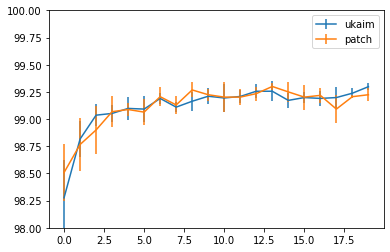

In [ ]:
plot_results([avg_accs_sota_ukaim_wd00005_results, avg_accs_patchinit_wd00005_results], ['ukaim', 'patch'], [std_accs_sota_ukaim_wd00005_results, std_accs_patchinit_wd00005_results], 98)

## WD = 0.005

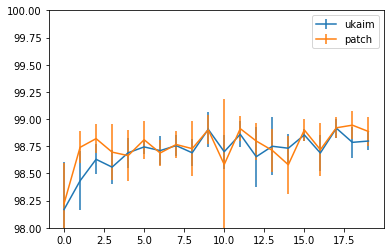

In [ ]:
plot_results([avg_accs_sota_ukaim_wd0005_results, avg_accs_patchinit_wd0005_results], ['ukaim', 'patch'], [std_accs_sota_ukaim_wd0005_results, std_accs_patchinit_wd0005_results], 98)

## WD = 0.05

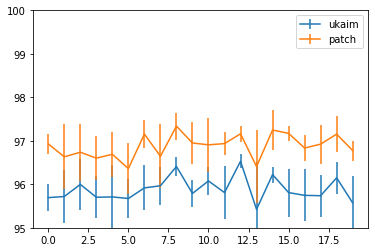

In [ ]:
plot_results([avg_accs_sota_ukaim_wd005_results, avg_accs_patchinit_wd005_results], ['ukaim', 'patch'], [std_accs_sota_ukaim_wd005_results, std_accs_patchinit_wd005_results], 95.)

## WD = 0.00005

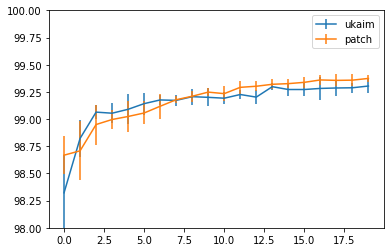

In [ ]:
plot_results([avg_accs_sota_ukaim_wd000005_results, avg_accs_patchinit_wd000005_results], ['ukaim', 'patch'], [std_accs_sota_ukaim_wd000005_results, std_accs_patchinit_wd000005_results], 98.)

## WD = 0.000005

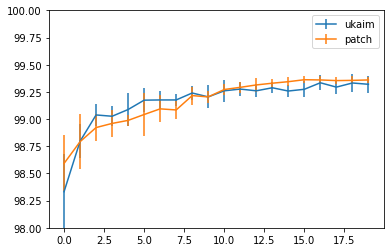

In [ ]:
plot_results([avg_accs_sota_ukaim_wd0000005_results, avg_accs_patchinit_wd0000005_results], ['ukaim', 'patch'], [std_accs_sota_ukaim_wd0000005_results, std_accs_patchinit_wd0000005_results], 98.)